#### Assignment 7
#### AAYUSH GOYAL
#### EE18BTECH11001

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import nestle
from astropy import stats as stats_astropy
from astroML import stats as stats_astroML

In [2]:
def model(z,a,b):
    return a*(1+b*z)

def log_prior(theta):
    a, b = theta
    if 0 < a < 0.5 and -0.5 < b < 0.5:
        return 0.0
    return -np.inf

In [3]:
def polynomial_fit(theta, x):
    return sum(t * x ** n for (n, t) in enumerate(theta))

def prior(theta):
    return 200*theta - 100

def log_post(theta,x,y,y_err):   
    func = model(z,*theta)
    sigma_2 = y_err ** 2 + func ** 2
    log_likeli =np.sum((y - func) ** 2 / sigma_2 + np.log(sigma_2))/-2
    return log_prior(theta)+log_likeli

In [4]:
def comp_sigma(t1, t2, nbins=20):
    L, xbins, ybins = np.histogram2d(t1, t2, nbins)
    L[L == 0] = 1e-16
    logL = np.log(L)
    shape = L.shape
    L = L.ravel()
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)
    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])
    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


In [5]:
def plot_MCMC_trace(xdata, ydata, t):
    xbins, ybins, sigma = comp_sigma(t[0], t[1])
    plt.contour(xbins, ybins, sigma.T, levels=[0.68, 0.90], colors='b')
    plt.plot(t[0], t[1], ',k', alpha=0.1)
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.title('68% & 90% Credible Interval')
    plt.show()

### Question 1 

In [6]:
da = np.loadtxt( 'https://iith.ac.in/~shantanud/fgas_spt.txt')
np.random.seed(42)
z = da[:,0]
nburn = 1000  
ndim = 2 
nwalkers = 50  
nsteps = 7000 

  0%|          | 0/7000 [00:00<?, ?it/s]/Users/aayush/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 7000/7000 [00:07<00:00, 912.77it/s]


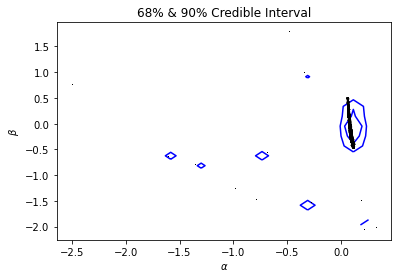

In [7]:
p_opt, p_cov = curve_fit(model, da[:,0], da[:,1],sigma = da[:,2])
starting_guesses = np.random.normal(p_opt, 1, (nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                log_post,args=[z,da[:,1],da[:,2]])
sampler.run_mcmc(starting_guesses, nsteps,progress = True)
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_trace(z, da[:,1], emcee_trace)

### Question 2 

In [8]:
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])


In [9]:
def log_llihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2)
                         + (y - yM) ** 2 / sigma_y ** 2)


In [10]:
x, y, sigma_y = data
np.random.seed(42)
result_lin = nestle.sample(log_llihood, prior, 2)
print(result_lin.summary())
result_quad = nestle.sample(log_llihood, prior, 3)
print()
print(result_quad.summary())

niter: 1595
ncall: 2678
nsamples: 1695
logz:  6.909 +/-  0.374
h: 13.989

niter: 2097
ncall: 3954
nsamples: 2197
logz:  2.752 +/-  0.433
h: 18.737


Values Dont agree with the blog

### Question 3

In [11]:
df = pd.read_csv('SDSS_quasar.dat',sep = '\s+')
data2 = df['z']
data = data2.to_numpy()

x = np.linspace(-0.5,5.0,1000)
logpdfgaus = KernelDensity(kernel='gaussian', bandwidth=0.2
                          ).fit(data[:,np.newaxis]
                               ).score_samples(x[:,np.newaxis])
pdf_g = np.exp(logpdfgaus)
logpdfexp = KernelDensity(kernel='exponential',bandwidth=0.2
                         ).fit(data[:,np.newaxis]
                              ).score_samples(x[:,np.newaxis])
pdf_exp = np.exp(logpdfexp)


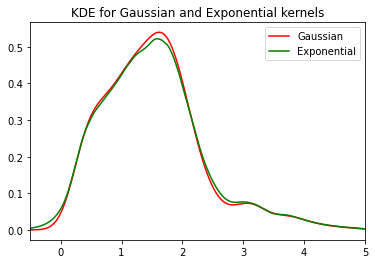

In [12]:
plt.plot(x,pdf_g,'r',label = 'Gaussian')
plt.plot(x,pdf_exp,'g',label = 'Exponential')
plt.legend()
plt.title('KDE for Gaussian and Exponential kernels')
plt.xlim(-0.5,5)
plt.show()